# Data Collection Pipeline

*Oskar schade

This notebook comprises the collection pipeline used in the project.

*   Reference imagery is loaded on an interactive map
*   An Area of Interest is defined by drawing a rectangle on the map
*   Image patches are collected in a sliding window (size in meters and pixels can be adjusted)
*   Patches are inspected visualy for verification
*   OSM data is collected for each patch, and converted to image files
*   Masks are inspected visually, overlaid on images.

As the imagery used must be located in a specified directory, this notebook should not be viewed as fully functioning code, but an illustrative example of the collection pipeline used in this project. In this particular example, to image sources are used, which are both imported as layers on the map and are derived from OpenAerialMap.

*The architecture of the intial few cells of this notebook have drawn inspiration from the following source:
https://samgeo.gishub.org/examples/automatic_mask_generator/

## Installation and general imports

In [ ]:
%pip install segment-geospatial
!pip install geopandas shapely rasterio
!pip install osmnx==1.3.0 # There is an issue regarding osmnx, wherefore the version is specified

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import leafmap
import rasterio
import shutil
from rasterio.mask import mask as rio_mask
from rasterio.features import rasterize
from rasterio.warp import reproject, Resampling
from samgeo import SamGeo, show_image, download_file, tms_to_geotiff
from shapely.geometry import box
from pyproj import Transformer
from PIL import Image
from io import BytesIO

## Defining reference imagery to be used for collection

*The notebook was develop in Google Collab, wherefore images are loaded via google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Defining paths in Google Drive where reference imagery is saved
reference_image_1 = # *Path to a google drive directory*
reference_image_2 = # *Path to a google drive directory*

Mounted at /content/drive


## Creating an interactive map and defining Area of Interest (AOI)

In [ ]:
# Initializing the interactive map and centering on the approximate location of the camp I am interested in
m = leafmap.Map(center=[-13.659415097552325, 33.870431184768684], zoom=17, height="800px")

# Loading reference imagery as leafmap layers along with a sattelite basemap
m.add_raster(reference_image_1, layer_name="Dzaleka South")
m.add_raster(reference_image_2, layer_name="Dzaleka North Reprojected")
m.add_basemap("SATELLITE")

# Displaying the interactive map
m


Map(center=[-13.650783, 33.8689185], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [ ]:
# Defining the AOI as the box drawn by the user in the interactive map
AOI = m.user_roi_bounds()

## Meta data inspection

In [ ]:
# Function for displaying meta data
def tif_metadata(tif_file):
    with rasterio.open(tif_file) as src:
        print(f"File {tif_file}:")
        print("Dimensions:", src.width, src.height)
        print("Resolution:", src.res)
        print("Cordinate system (CRS):", src.crs)
        print("Bounds:", src.bounds)
        print("Bands:", src.count)

tif_metadata(reference_image_1)
tif_metadata(reference_image_2)



File /content/drive/MyDrive/Thesis/Data/Dzaleka_sources/Dzaleka_south.tif:
Dimensions: 41974 65170
Resolution: (0.0346, 0.0346)
Cordinate system (CRS): EPSG:3857
Bounds: BoundingBox(left=3769750.0248539285, bottom=-1536642.233168092, right=3771202.3252539285, top=-1534387.351168092)
Bands: 3
File /content/drive/MyDrive/Thesis/Data/Dzaleka_sources/Dzaleka_north_reprojected.tif:
Dimensions: 29009 21802
Resolution: (0.049999228445453, 0.049999228445453)
Cordinate system (CRS): EPSG:3857
Bounds: BoundingBox(left=3769545.566719401, bottom=-1534726.978042519, right=3770995.9943373753, top=-1533636.8948639513)
Bands: 3


## Reprojecting the AOI

In [ ]:
# Defining a transformer to change the coordinate system of the AOI
aoi_transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

min_lon, min_lat, max_lon, max_lat = AOI

min_x, min_y = aoi_transformer.transform(min_lon, min_lat)
max_x, max_y = aoi_transformer.transform(max_lon, max_lat)

AOI_3857 = [min_x, min_y, max_x, max_y]

_____________________________________________________

## Sliding window patch sampling

- overlap: 20%
- patch size in meters: 100x100
- final patch size in pixels: 512x512

### Defining functions and setting parameters for the sliding window

In [ ]:
# Defining overlap, patch count, patch size in meters and pixels, and the step size taken by the sliding window

patch_size_meters = 100
patch_size_pixels = 512
overlap = 0.2
step_size = patch_size_meters * (1 - overlap)
patch_count = 0

# Function for checking whether the bounding box intersects the reference imagery in the AOI
def check_intersection(tif_file, AOI_3857):
    with rasterio.open(tif_file) as src:
        tif_bounds = src.bounds
        return not (AOI_3857[2] < tif_bounds.left or AOI_3857[0] > tif_bounds.right or
                    AOI_3857[3] < tif_bounds.bottom or AOI_3857[1] > tif_bounds.top)


# Function for extracting the image within the specified area
def extract_image(tif_file, AOI_3857):
    if not check_intersection(tif_file, AOI_3857):  # Checking intersection
        return None, None, None

    with rasterio.open(tif_file) as src:
        AOI_geom = [box(AOI_3857[0], AOI_3857[1], AOI_3857[2], AOI_3857[3])]
        # Extracting the image if there is no intersect error
        try:
            out_image, out_transform = rio_mask(src, AOI_geom, crop=True)
            return out_image, src.meta, out_transform
        except ValueError:
            print("Intersect error!")
            return None, None, None


# Function for resizing the image to the desired patch size in pixels
def resize_image(image, src_transform, src_crs, target_shape, target_transform, target_crs="EPSG:3857"):
    resized_image = np.empty(shape=(image.shape[0], target_shape[0], target_shape[1]), dtype=image.dtype)

    for i in range(image.shape[0]):
        reproject(
            source=image[i],
            destination=resized_image[i],
            src_transform=src_transform,
            dst_transform=target_transform,
            src_crs=src_crs,
            dst_crs=target_crs,
            resampling=Resampling.bilinear)
    return resized_image


# Function for retrieving satellite imagery, if the defined area is not covered by the reference imagery
def retrieve_satellite_image(patch_AOI, output_path, zoom=21):
    # Ensuring that coordinate system complies with the satellite basemap
    sat_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    min_lon, min_lat = sat_transformer.transform(patch_AOI[0], patch_AOI[1])
    max_lon, max_lat = sat_transformer.transform(patch_AOI[2], patch_AOI[3])

    # Retrieving satellite image
    AOI = [min_lon, min_lat, max_lon, max_lat]
    tms_to_geotiff(output=output_path, bbox=AOI, zoom=zoom, source="Satellite", overwrite=True)

    # Reading the image as an array and resizing to the desired patch size
    with rasterio.open(output_path) as src:
        image = src.read([1, 2, 3]) # RGB encoding
        image_resized = np.empty((3, patch_size_pixels, patch_size_pixels), dtype=image.dtype)
        target_transform = rasterio.transform.from_bounds(patch_AOI[0], patch_AOI[1], patch_AOI[2], patch_AOI[3], patch_size_pixels, patch_size_pixels)

        for i in range(3):
            reproject(
                source=image[i],
                destination=image_resized[i],
                src_transform=src.transform,
                dst_transform=target_transform,
                src_crs=src.crs,
                dst_crs="EPSG:3857",
                resampling=Resampling.bilinear)
    return image_resized


# Function for extracting patch from the reference imagery
def extract_patch(AOI_3857, reference_image_1, reference_image_2, patch_min_x, patch_min_y):
    # Defining an area for the single patch, based on the desired size in meters
    patch_AOI = [patch_min_x, patch_min_y, patch_min_x + patch_size_meters, patch_min_y + patch_size_meters]
    south_image = None
    north_image = None

    # Ensuring that sizes in meters vs. pixel conform
    target_transform = rasterio.transform.from_bounds(
        patch_min_x, patch_min_y,
        patch_min_x + patch_size_meters,
        patch_min_y + patch_size_meters,
        patch_size_pixels,
        patch_size_pixels)

    # Extracting the patch and resize if it intersect with the first tif file
    if check_intersection(reference_image_1, patch_AOI):
        south_image, south_meta, south_transform = extract_image(reference_image_1, patch_AOI)
        if south_image is not None:
            south_image = resize_image(south_image, south_transform, south_meta['crs'], (patch_size_pixels, patch_size_pixels), target_transform)

    # Extracting the patch and resize if it intersect with the second tif file
    if check_intersection(reference_image_2, patch_AOI):
        north_image, north_meta, north_transform = extract_image(reference_image_2, patch_AOI)
        if north_image is not None:
            north_image = resize_image(north_image, north_transform, north_meta['crs'], (patch_size_pixels, patch_size_pixels), target_transform)
    # Defining satellite imagery, if this is to be retrieved
    sat_path = "satellite_patch.tif"

    # Retrieving sattelite imagery if the defined area is not covered by the tif files
    if south_image is None and north_image is None:
        combined_image = retrieve_satellite_image(patch_AOI, sat_path)
    else:
        combined_image = np.zeros((3, patch_size_pixels, patch_size_pixels), dtype=np.uint8)
        if south_image is not None:
            combined_image = np.maximum(combined_image, south_image)
        if north_image is not None:
            combined_image = np.maximum(combined_image, north_image)
        # Filling any smaller areas not covered by the reference imagery, with the satellite basemap
        satellite_image = retrieve_satellite_image(patch_AOI, sat_path)
        mask = combined_image == 0
        combined_image[mask] = satellite_image[mask]

    return combined_image

### Collection loop

In [ ]:
# Collecting patches in the sliding window
for y in range(0, int(AOI_3857[3] - AOI_3857[1]), int(step_size)):
    for x in range(0, int(AOI_3857[2] - AOI_3857[0]), int(step_size)):

        # Defining the coordinates of the patch and extracting it
        patch_min_x = AOI_3857[0] + x
        patch_min_y = AOI_3857[1] + y
        patch_image = extract_patch(AOI_3857, reference_image_1, reference_image_2, patch_min_x, patch_min_y)

        # Saving the patch if it is retrieved
        if patch_image is not None:
            patch_count += 1
            print(f"Patch #{patch_count} generated at (min_x: {patch_min_x}, min_y: {patch_min_y})")
            patch_name = f"patch_{x}_{y}.tif"
            with rasterio.open(
                patch_name,
                "w",
                driver="GTiff",
                height=patch_image.shape[1], width=patch_image.shape[2],
                count=3, # RGB encoding
                dtype=patch_image.dtype,
                crs="EPSG:3857",
                transform=rasterio.transform.from_bounds(
                    patch_min_x, patch_min_y,
                    patch_min_x + patch_size_meters,
                    patch_min_y + patch_size_meters,
                    patch_size_pixels,
                    patch_size_pixels
                ),
            ) as dst:
                dst.write(patch_image)

## Visual inspection of patches for verification

Number of patches generated: 25


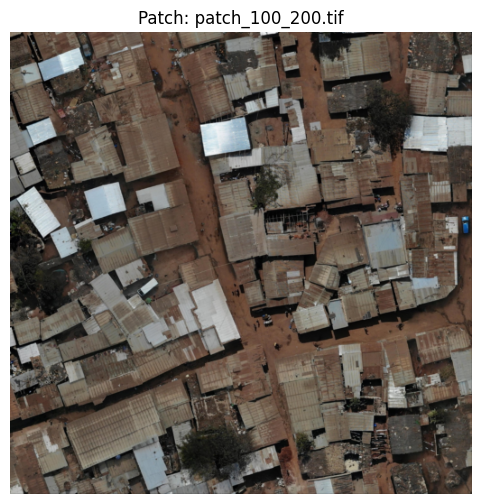

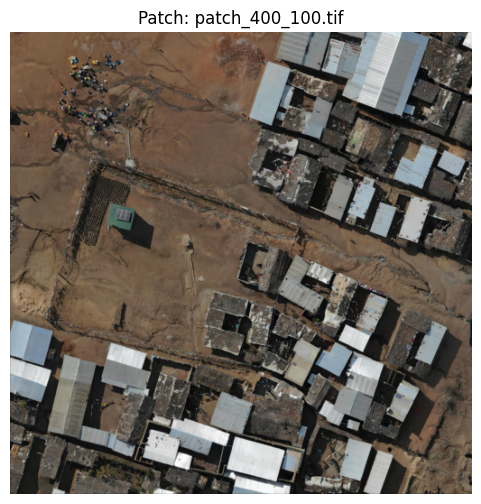

/usr/local/lib/python3.10/dist-packages/matplotlib/artist.py:1184: ResourceWarning: unclosed <ssl.SSLSocket fd=132, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34210), raddr=('142.251.2.101', 443)>
  with cbook._setattr_cm(self, eventson=False):
/usr/local/lib/python3.10/dist-packages/matplotlib/artist.py:1184: ResourceWarning: unclosed <ssl.SSLSocket fd=123, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34178), raddr=('142.251.2.101', 443)>
  with cbook._setattr_cm(self, eventson=False):
/usr/local/lib/python3.10/dist-packages/matplotlib/artist.py:1184: ResourceWarning: unclosed <ssl.SSLSocket fd=126, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34192), raddr=('142.251.2.101', 443)>
  with cbook._setattr_cm(self, eventson=False):
/usr/local/lib/python3.10/dist-packages/matplotlib/artist.py:1184: ResourceWarning: unclosed <ssl.SSLSocket fd=124, family=A

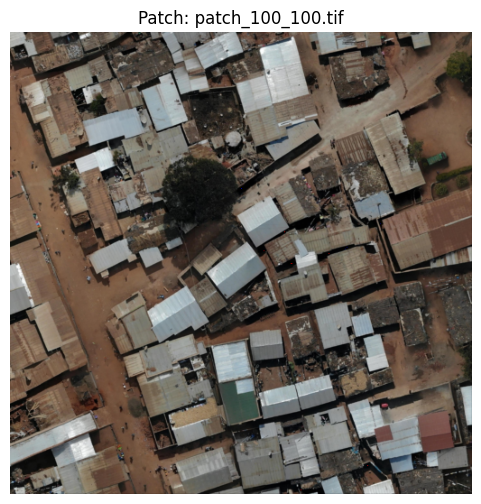

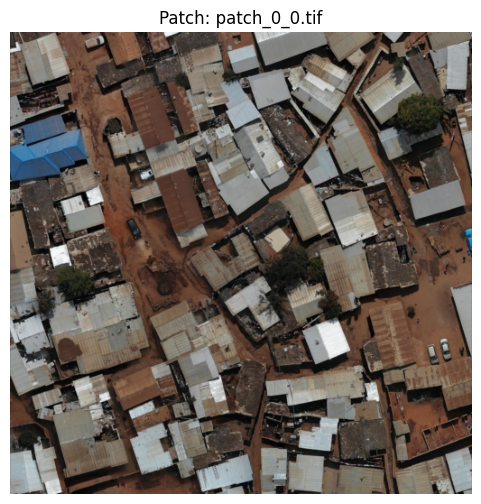

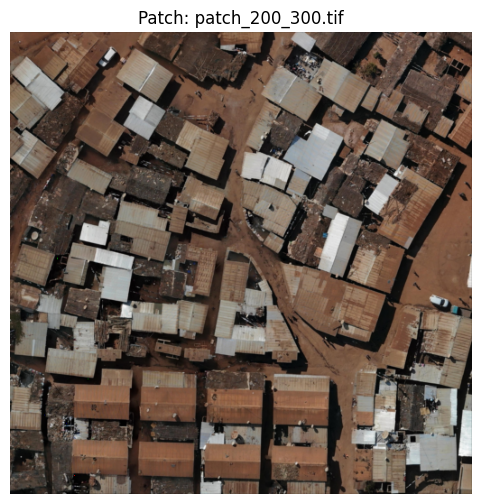

In [ ]:
output_directory = "." # Defining temporary working directory for patches

# Printing the file names of patches
patch_files = [f for f in os.listdir(output_directory) if f.startswith("patch_") and f.endswith(".tif")]
total_patches = len(patch_files)
print(f"Number of patches generated: {total_patches}")

# Displaying a number of randomly selected patches for visual inspection
display_amount = 5  # Setting a number of random patches to display
random_patches = random.sample(patch_files, min(display_amount, total_patches))

for patch_file in random_patches:
    with rasterio.open(os.path.join(output_directory, patch_file)) as src:
        patch_image = src.read([1, 2, 3])
    plt.figure(figsize=(6, 6))
    plt.imshow(patch_image.transpose(1, 2, 0))
    plt.title(f"Patch: {patch_file}")
    plt.axis('off')
    plt.show()


## Mask generation

In [ ]:
# Defining working directories for image and mask patches inside the notebook
image_patches_directory = "."
mask_output_directory = "masks"
os.makedirs(mask_output_directory, exist_ok=True)

# Defining OSM tag for retrieving dwellings
tags = {'building': True}

# Function for generating mask for each patch
def generate_mask(patch_name):
    patch_filepath = os.path.join(image_patches_directory, patch_name) # Setting path for the given patch

    with rasterio.open(patch_filepath) as patch:
        patch_transform = patch.transform
        min_x, min_y = patch_transform * (0, patch.height)
        max_x, max_y = patch_transform * (patch.width, 0)
        patch_AOI = [min_x, min_y, max_x, max_y]

        # Ensuring the coordinate system used complies with the image source
        patch_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
        min_lon, min_lat = patch_transformer.transform(min_x, min_y)
        max_lon, max_lat = patch_transformer.transform(max_x, max_y)

        # Retrieving OSM Annotation for the patch
        print(f"Retrieving annotations for: {patch_name}")
        try:
            buildings = ox.geometries.geometries_from_bbox(max_lat, min_lat, max_lon, min_lon, tags)
            buildings = buildings[buildings.geometry.type == 'Polygon']
        except Exception as e:
            print(f"Could not retrieve annotations for {patch_name}: {e}") # Handling errors
            buildings = gpd.GeoDataFrame()

        # Checking if any buildings were found and print the number of polygons in the OSM data
        if buildings.empty:
            print(f"No buildings in {patch_name}.")
            mask = np.zeros((patch_size_pixels, patch_size_pixels), dtype=np.uint8)
        else:
            print(f"Retrieved {len(buildings)} polygons")

            # Again, ensuring that the coordinate system is correct
            buildings = buildings.to_crs("EPSG:3857")
            # Converting the vector data to a raster image
            raster_conversion = rasterio.transform.from_bounds(
                patch_AOI[0], patch_AOI[1], patch_AOI[2], patch_AOI[3],
                patch_size_pixels, patch_size_pixels)

            # Defining mask
            mask = rasterize(
                [(geom, 1) for geom in buildings.geometry],
                out_shape=(patch_size_pixels, patch_size_pixels),
                transform=raster_conversion,
                fill=0,
                dtype='uint8')

        # Saving the mask with a name similar to the image, such that they may be paired
        mask_filepath = os.path.join(mask_output_directory, f"mask_{patch_name}")
        with rasterio.open(
            mask_filepath,
            "w",
            driver="GTiff",
            height=mask.shape[0],
            width=mask.shape[1],
            count=1,
            dtype=mask.dtype,
            crs="EPSG:3857",
            transform=patch_transform,
        ) as dst:
            dst.write(mask, 1)

# Gathering all patch files in a list
patch_files = [f for f in os.listdir(image_patches_directory) if f.startswith("patch_") and f.endswith(".tif")]

# Genering masks for all patches
for patch_file in patch_files:
    generate_mask(patch_file)

print("Masks generated for all images!")


Retrieving annotations for: patch_400_100.tif
Retrieved 97 polygons
Retrieving annotations for: patch_200_100.tif
Retrieved 136 polygons
Retrieving annotations for: patch_100_200.tif
Retrieved 173 polygons
Retrieving annotations for: patch_100_100.tif
Retrieved 124 polygons
Retrieving annotations for: patch_400_300.tif
Retrieved 148 polygons
Retrieving annotations for: patch_300_200.tif
Retrieved 163 polygons
Retrieving annotations for: patch_200_400.tif
Retrieved 78 polygons
Retrieving annotations for: patch_300_0.tif
Retrieved 130 polygons
Retrieving annotations for: patch_200_300.tif
Retrieved 168 polygons
Retrieving annotations for: patch_0_100.tif
Retrieved 100 polygons
Retrieving annotations for: patch_100_0.tif
Retrieved 111 polygons
Retrieving annotations for: patch_0_0.tif
Retrieved 124 polygons
Retrieving annotations for: patch_300_300.tif
Retrieved 142 polygons
Retrieving annotations for: patch_0_300.tif
Retrieved 97 polygons
Retrieving annotations for: patch_400_0.tif
Retri

## Visual inspection of masks on images for verification

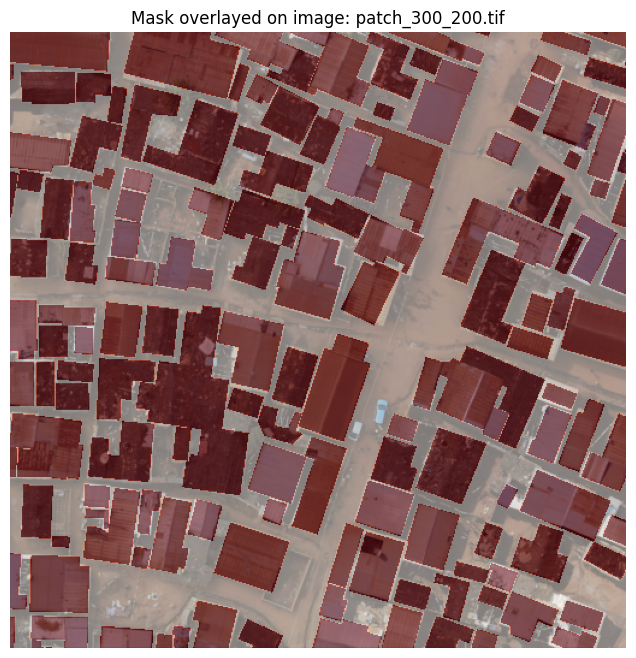

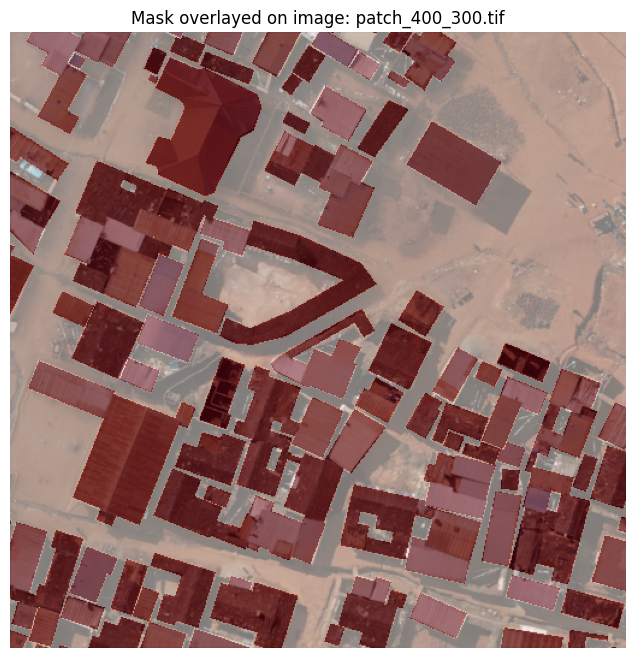

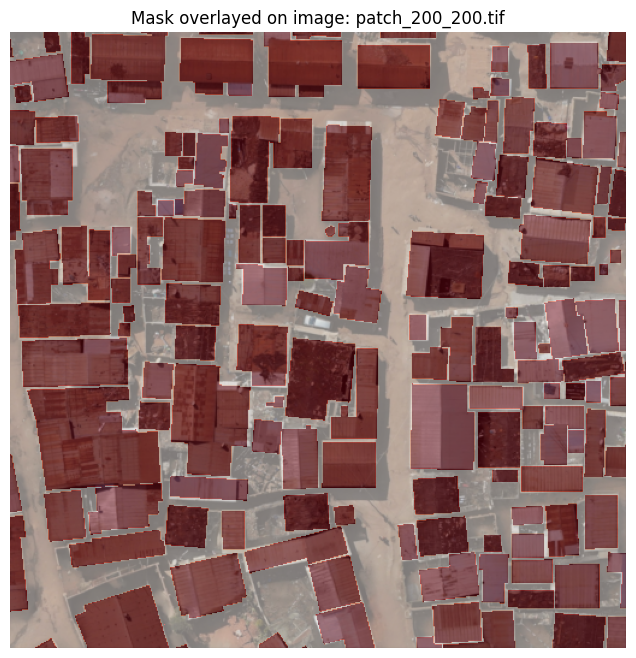

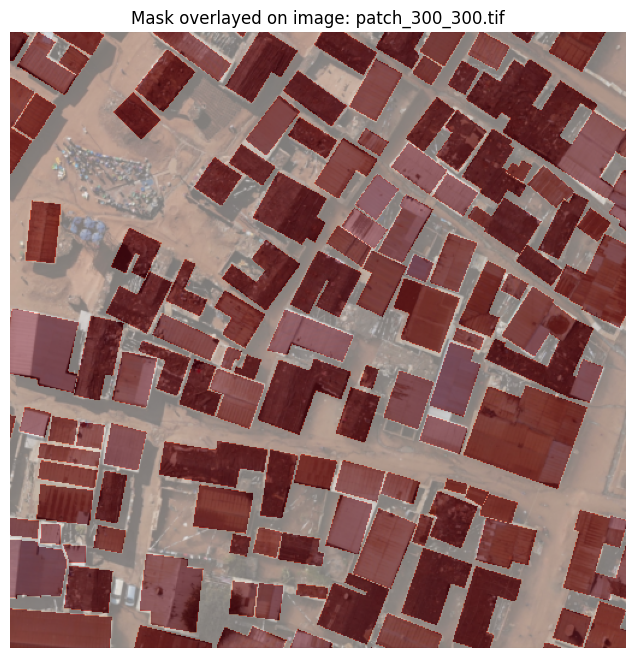

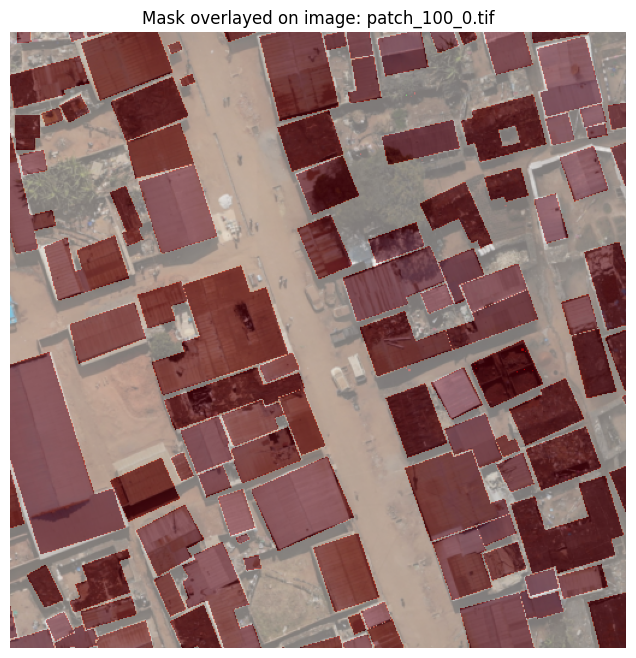

In [ ]:
# Function for overlaying a mask on an image
def overlay_mask_on_image(image_file, mask_file, alpha=0.5): # Setting the overlay to be transparent
    #opening image and mask with rasterio
    with rasterio.open(image_file) as src_img:
        image = src_img.read([1, 2, 3])
        image_transform = src_img.transform
    with rasterio.open(mask_file) as src_mask:
        mask = src_mask.read(1)
        mask_transform = src_mask.transform
    # Displaying the overlay
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(np.moveaxis(image, 0, -1))
    ax.imshow(mask, cmap="Reds", alpha=alpha)
    plt.axis("off")
    plt.title(f"Mask overlayed on image: {os.path.basename(image_file)}")
    plt.show()

# Gathering all images and masks in lists via the designated filenames
image_files = [f for f in os.listdir(image_patches_directory) if f.startswith("patch_") and f.endswith(".tif")]
mask_files = [f.replace("patch_", "mask_patch_") for f in image_files]

# Displaying a number of randomly selected patches for visual inspection
display_amount = 5  # Setting a number of random patches to display
rand_ind = random.sample(range(len(image_files)), min(display_amount, len(image_files)))

for i in rand_ind:
    image_file = os.path.join(image_patches_directory, image_files[i])
    mask_file = os.path.join(mask_output_directory, mask_files[i])
    overlay_mask_on_image(image_file, mask_file)


## Verifying that all images have corresponding masks

In [ ]:
# Finding all image and mask files
patch_files = [f for f in os.listdir(image_patches_directory) if f.startswith("patch_") and f.endswith(".tif")]
mask_files = [f for f in os.listdir(mask_output_directory) if f.startswith("mask_patch_") and f.endswith(".tif")]

# Checking if the number of images and masks is identical
if len(patch_files) != len(mask_files):
    print("Mismatch in number of masks and images!")
else:
    print(f"Matching number of masks and images: {len(patch_files)}")

patch_set = set([f"mask_{patch}" for patch in patch_files])
mask_set = set(mask_files)

# Asserting whether there any images that have no corresponding masks
no_masks = patch_set - mask_set
if no_masks:
    print("Images with no masks found")
    for image_name in no_masks:
        print(image_name.replace("mask_", ""))
else:
    print("Masks found for all image patches!")


________________________________________________________________________________